In [109]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

In [110]:
data = pd.read_csv(r'C:\Users\theom\Desktop\INFRATAL\MonteCarlo TAL\Database\df_currency_10y.csv', parse_dates=True)

In [111]:
data['TALUSD'] = (1/data['USDCHF'])*100 + (1/data['USDEUR'])*250 + (1/data['USDGBP'])*50 + (1/data['USDJPY'])*18000 + (1/data['USDCNY'])*1600 + (1/data['USDSGD']*80) + ((data['USDGOLD'])*0.2)

data['TALUSD'] = data['TALUSD']*0.001


In [114]:
data['TALUSD'].to_csv('TALUSD.csv')

In [115]:
currency_columns = ['USDCHF', 'USDEUR', 'USDGBP', 'USDJPY', 'USDCNY', 'USDSGD', 'USDGOLD','TALUSD']
returns = data[currency_columns].pct_change().dropna()


In [116]:
returns = returns.sort_index()

<AxesSubplot:>

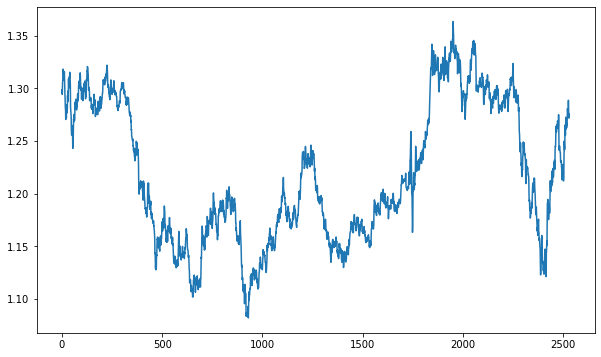

In [117]:

data['TALUSD'].plot(figsize=(10,6))

<AxesSubplot:>

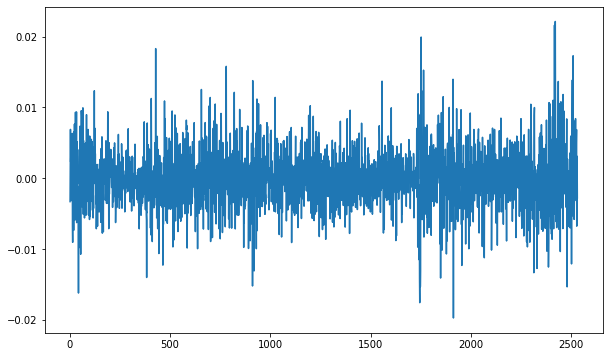

In [118]:
returns['TALUSD'].plot(figsize=(10,6))


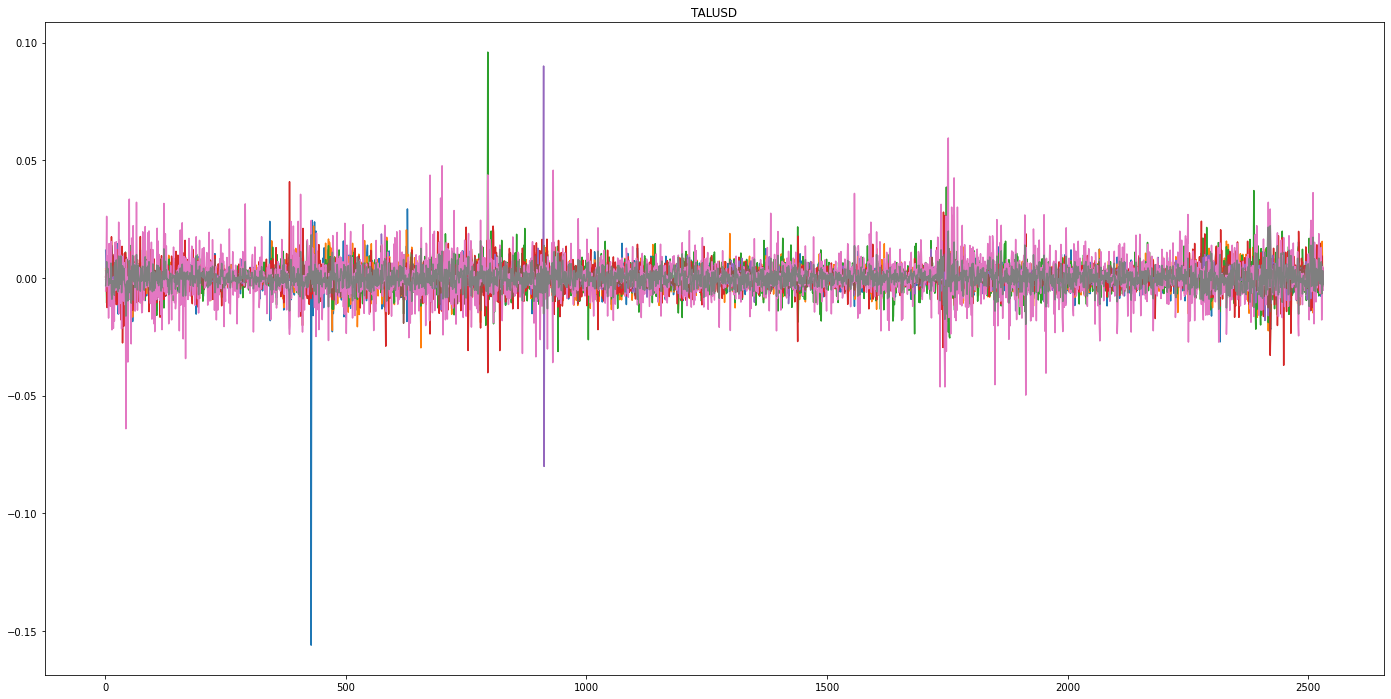

In [119]:
for i in range(0, len(returns.columns)):
    returns[returns.columns[i]].plot(figsize=(24,12), title=returns.columns[i])

In [120]:
def monte_carlo_simulation(returns, num_simulations, num_days):
    # Get the number of currencies
    num_currencies = len(returns.columns)
    
    # Create an empty 3D array to store the results
    results = np.zeros((num_simulations, num_days, num_currencies))

    # Calculate mean and standard deviation for each currency
    means = returns.mean()
    stds = returns.std()

    # Iterate over the number of simulations
    for sim in range(num_simulations):
        # Generate random daily returns from the fitted normal distributions
        random_returns = np.array([norm.rvs(loc=mean, scale=std, size=num_days) for mean, std in zip(means, stds)]).T

        # Calculate the cumulative product of (1 + random_returns)
        cum_random_returns = np.cumprod(1 + random_returns, axis=0)
        
        # Multiply the initial price (1) with the cumulative returns to get the price path
        price_path = cum_random_returns
        
        # Store the price path in the results array
        results[sim, :, :] = price_path

    return results


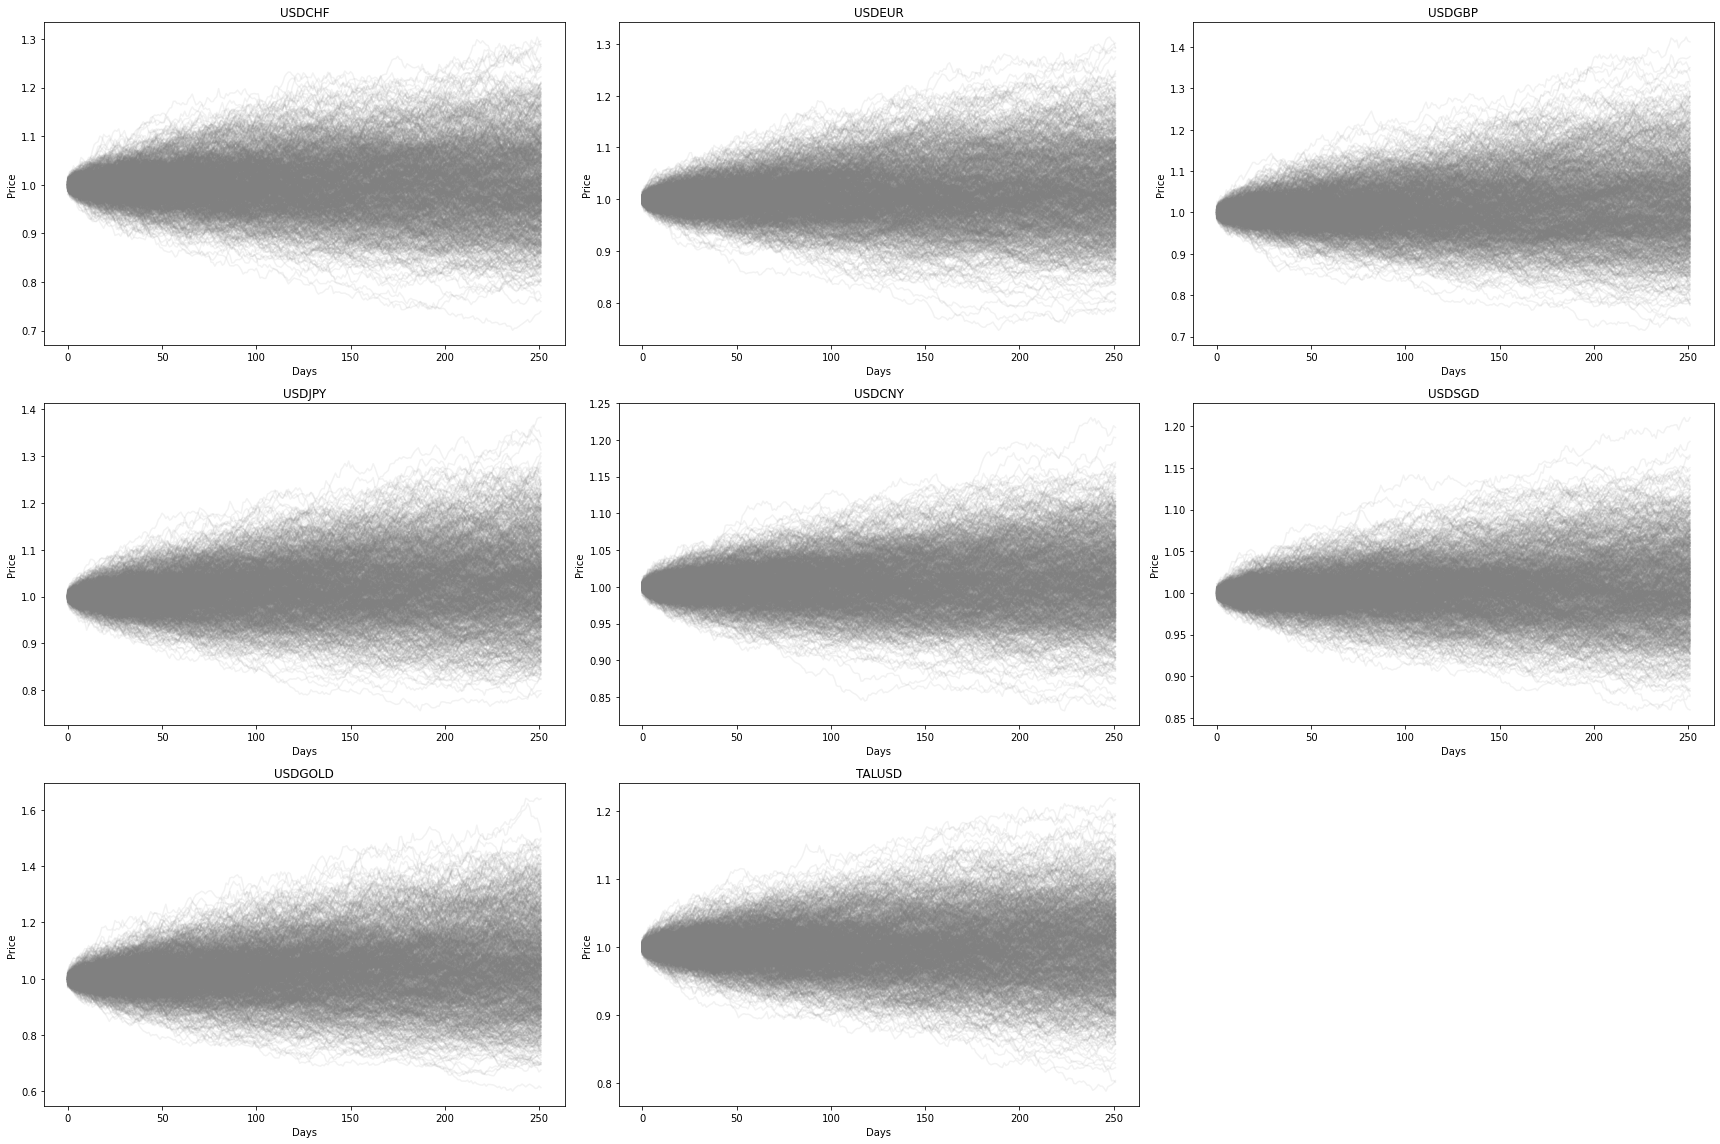

In [121]:
num_simulations = 1000
num_days = 252  # Number of trading days in a year

results = monte_carlo_simulation(returns, num_simulations, num_days)

# Plot the results
plt.figure(figsize=(24, 16))  # Increase the figure size to fit the new currency

for curr_idx, curr_name in enumerate(currency_columns):
    plt.subplot(3, 3, curr_idx + 1)  # Update the subplot layout
    plt.title(curr_name)

    for sim in range(num_simulations):
        plt.plot(results[sim, :, curr_idx], color='grey', alpha=0.1)

    plt.xlabel('Days')
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


  Currency      Mean    Median  Standard Deviation  5th Percentile  \
0   USDCHF  0.999800  0.991367            0.091692        0.859956   
1   USDEUR  1.019125  1.015732            0.082342        0.891102   
2   USDGBP  1.022737  1.014446            0.104329        0.861275   
3   USDJPY  1.034737  1.032202            0.095079        0.881015   
4   USDCNY  1.010864  1.008380            0.056167        0.925930   
5   USDSGD  1.009092  1.006644            0.051181        0.928906   
6  USDGOLD  1.042497  1.031310            0.160761        0.798492   
7   TALUSD  0.998351  0.998822            0.064062        0.895476   

   95th Percentile  
0         1.163362  
1         1.161937  
2         1.208094  
3         1.197715  
4         1.106355  
5         1.096511  
6         1.331106  
7         1.101503  


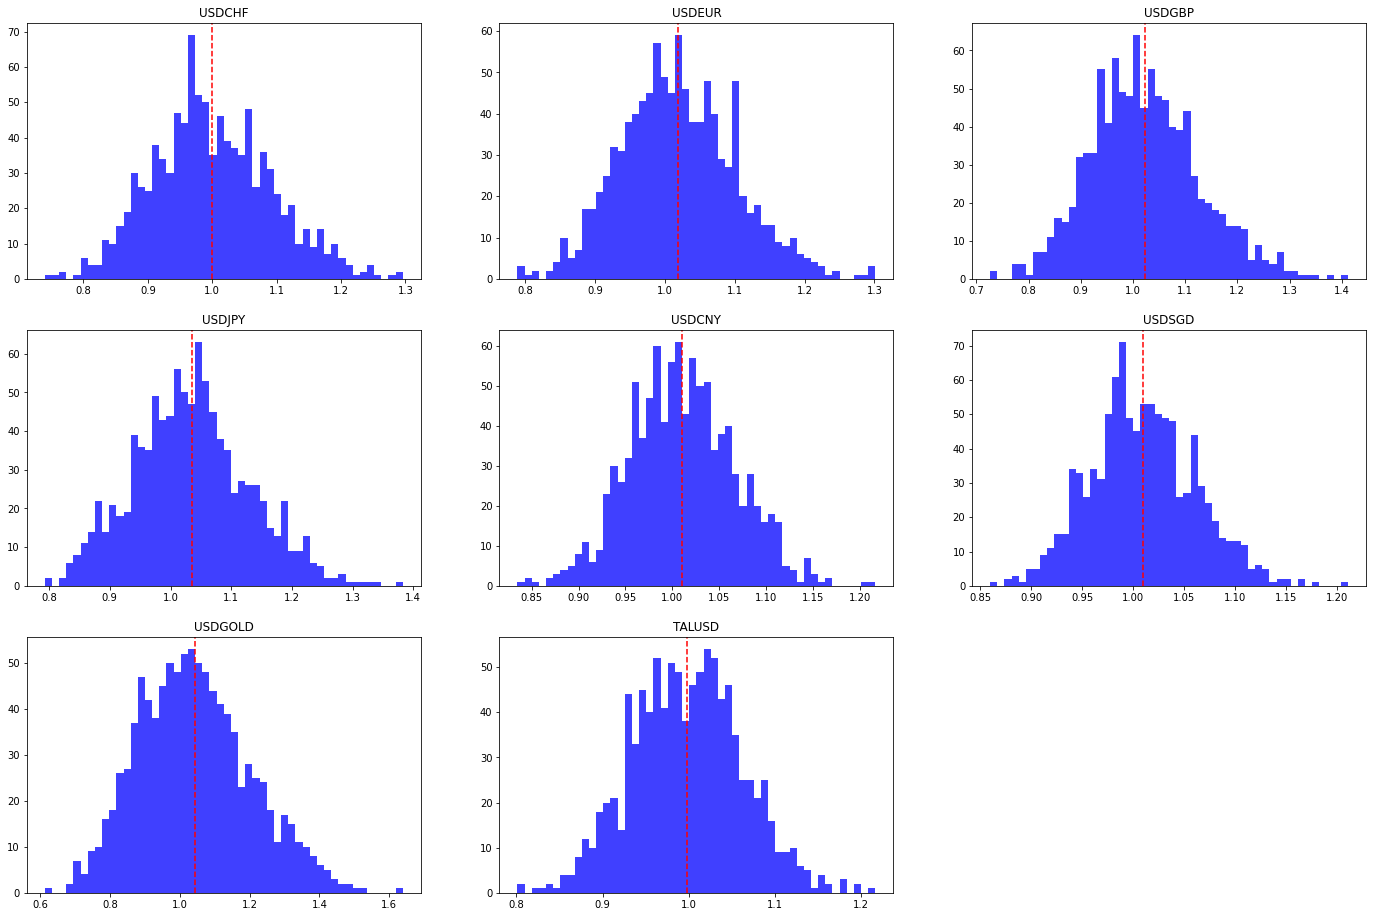

In [122]:
# Calculate the ending prices of each simulation
ending_prices = results[:, -1, :]

# Calculate summary statistics for each currency
mean_ending_prices = np.mean(ending_prices, axis=0)
median_ending_prices = np.median(ending_prices, axis=0)
std_ending_prices = np.std(ending_prices, axis=0)

# Calculate the 5th and 95th percentiles for each currency
percentiles = np.percentile(ending_prices, [5, 95], axis=0)

# Display the summary statistics
summary_statistics = pd.DataFrame({
    'Currency': currency_columns,
    'Mean': mean_ending_prices,
    'Median': median_ending_prices,
    'Standard Deviation': std_ending_prices,
    '5th Percentile': percentiles[0],
    '95th Percentile': percentiles[1],
})

print(summary_statistics)

# Plot the histograms
plt.figure(figsize=(24, 16))  # Increase the figure size to fit the new currency

for curr_idx, curr_name in enumerate(currency_columns):
    plt.subplot(3, 3, curr_idx + 1)  # Update the subplot layout
    plt.title(curr_name)
    plt.hist(ending_prices[:, curr_idx], bins=50, alpha=0.75, color='blue')
    plt.axvline(mean_ending_prices[curr_idx], color='red', linestyle='--', label='Mean')
    plt


In [123]:
stdTAL = returns['TALUSD'].std()
print('Standard Deviation of TAL is: ', stdTAL)

Standard Deviation of TAL is:  0.004113962433048077


In [124]:
def value_at_risk(std, confidence_level, time_horizon):
    return -norm.ppf(1 - confidence_level) * std * np.sqrt(time_horizon)
def expected_shortfall(returns, confidence_level=0.95):
    # Calculate the VaR
    var = -returns.quantile(1 - confidence_level)
    
    # Calculate the Expected Shortfall
    es = -returns[returns < -var].mean()
    
    return es


In [125]:
# Set the VaR parameters
confidence_level = 0.95
time_horizon = 1  # 1-day VaR

# Calculate the VaR
TAL_var = -norm.ppf(1 - confidence_level) * stdTAL * np.sqrt(time_horizon)
print(f"{round(100 * (1 - confidence_level),5)}% 1-day VaR:", TAL_var)
TAL_es = expected_shortfall(returns['TALUSD'], confidence_level)
print(f"Expected Shortfall at {confidence_level * 100}% confidence level:", TAL_es)

5.0% 1-day VaR: 0.006766866029141233
Expected Shortfall at 95.0% confidence level: 0.008993692532391667


In [126]:
ES = []
for i in currency_columns:
    ES.append(expected_shortfall(returns[i]))

VAR = []
for i in currency_columns:
    VAR.append(value_at_risk(returns[i].std(), confidence_level, time_horizon))

In [127]:
summary_statistics['VaR'] = VAR
summary_statistics['ES'] = ES

In [128]:
summary_statistics.to_csv('montecarlo_statistics.csv')

In [129]:
summary_statistics

,Currency,Mean,Median,Standard Deviation,5th Percentile,95th Percentile,VaR,ES
0,USDCHF,0.999800,0.991367,0.091692,0.859956,1.163362,0.009730,0.012578
1,USDEUR,1.019125,1.015732,0.082342,0.891102,1.161937,0.008310,0.011319
2,USDGBP,1.022737,1.014446,0.104329,0.861275,1.208094,0.010088,0.013089
3,USDJPY,1.034737,1.032202,0.095079,0.881015,1.197715,0.009481,0.013879
4,USDCNY,1.010864,1.008380,0.056167,0.925930,1.106355,0.005808,0.006827
5,USDSGD,1.009092,1.006644,0.051181,0.928906,1.096511,0.005089,0.007010
6,USDGOLD,1.042497,1.031310,0.160761,0.798492,1.331106,0.015801,0.022119
7,TALUSD,0.998351,0.998822,0.064062,0.895476,1.101503,0.006767,0.008994


In [130]:
stats_df = pd.DataFrame(summary_statistics)
stats_df['Mean'] -= 1
stats_df['Median'] -= 1
stats_df['5th Percentile'] -= 1
stats_df['95th Percentile'] -= 1
stats_df['VaR'] *= -1
stats_df['ES'] *= -1


In [131]:
def plot_mean(df, ax):
    df.plot(x="Currency", y="Mean", kind="bar", ax=ax, legend=False)
    ax.set_title("Mean")
    ax.set_ylabel("Price")


def plot_median(df, ax):
    df.plot(x="Currency", y="Median", kind="bar", ax=ax, legend=False)
    ax.set_title("Median")


def plot_std(df, ax):
    df.plot(x="Currency", y="Standard Deviation", kind="bar", ax=ax, legend=False)
    ax.set_title("Standard Deviation")
    ax.set_ylabel("Price")


def plot_var(df, ax):
    df.plot(x="Currency", y="VaR", kind="bar", ax=ax, legend=False)
    ax.set_title("Value at Risk (VaR)")


def plot_es(df, ax):
    df.plot(x="Currency", y="ES", kind="bar", ax=ax, legend=False)
    ax.set_title("Expected Shortfall (ES)")
    ax.set_ylabel("Price")


def plot_all(df):
    fig, axes = plt.subplots(5, 1, figsize=(24, 48))
    fig.subplots_adjust(hspace=0.4)

    plot_mean(df, axes[0])
    plot_median(df, axes[1])
    plot_std(df, axes[2])
    plot_var(df, axes[3])
    plot_es(df, axes[4])

    plt.show()

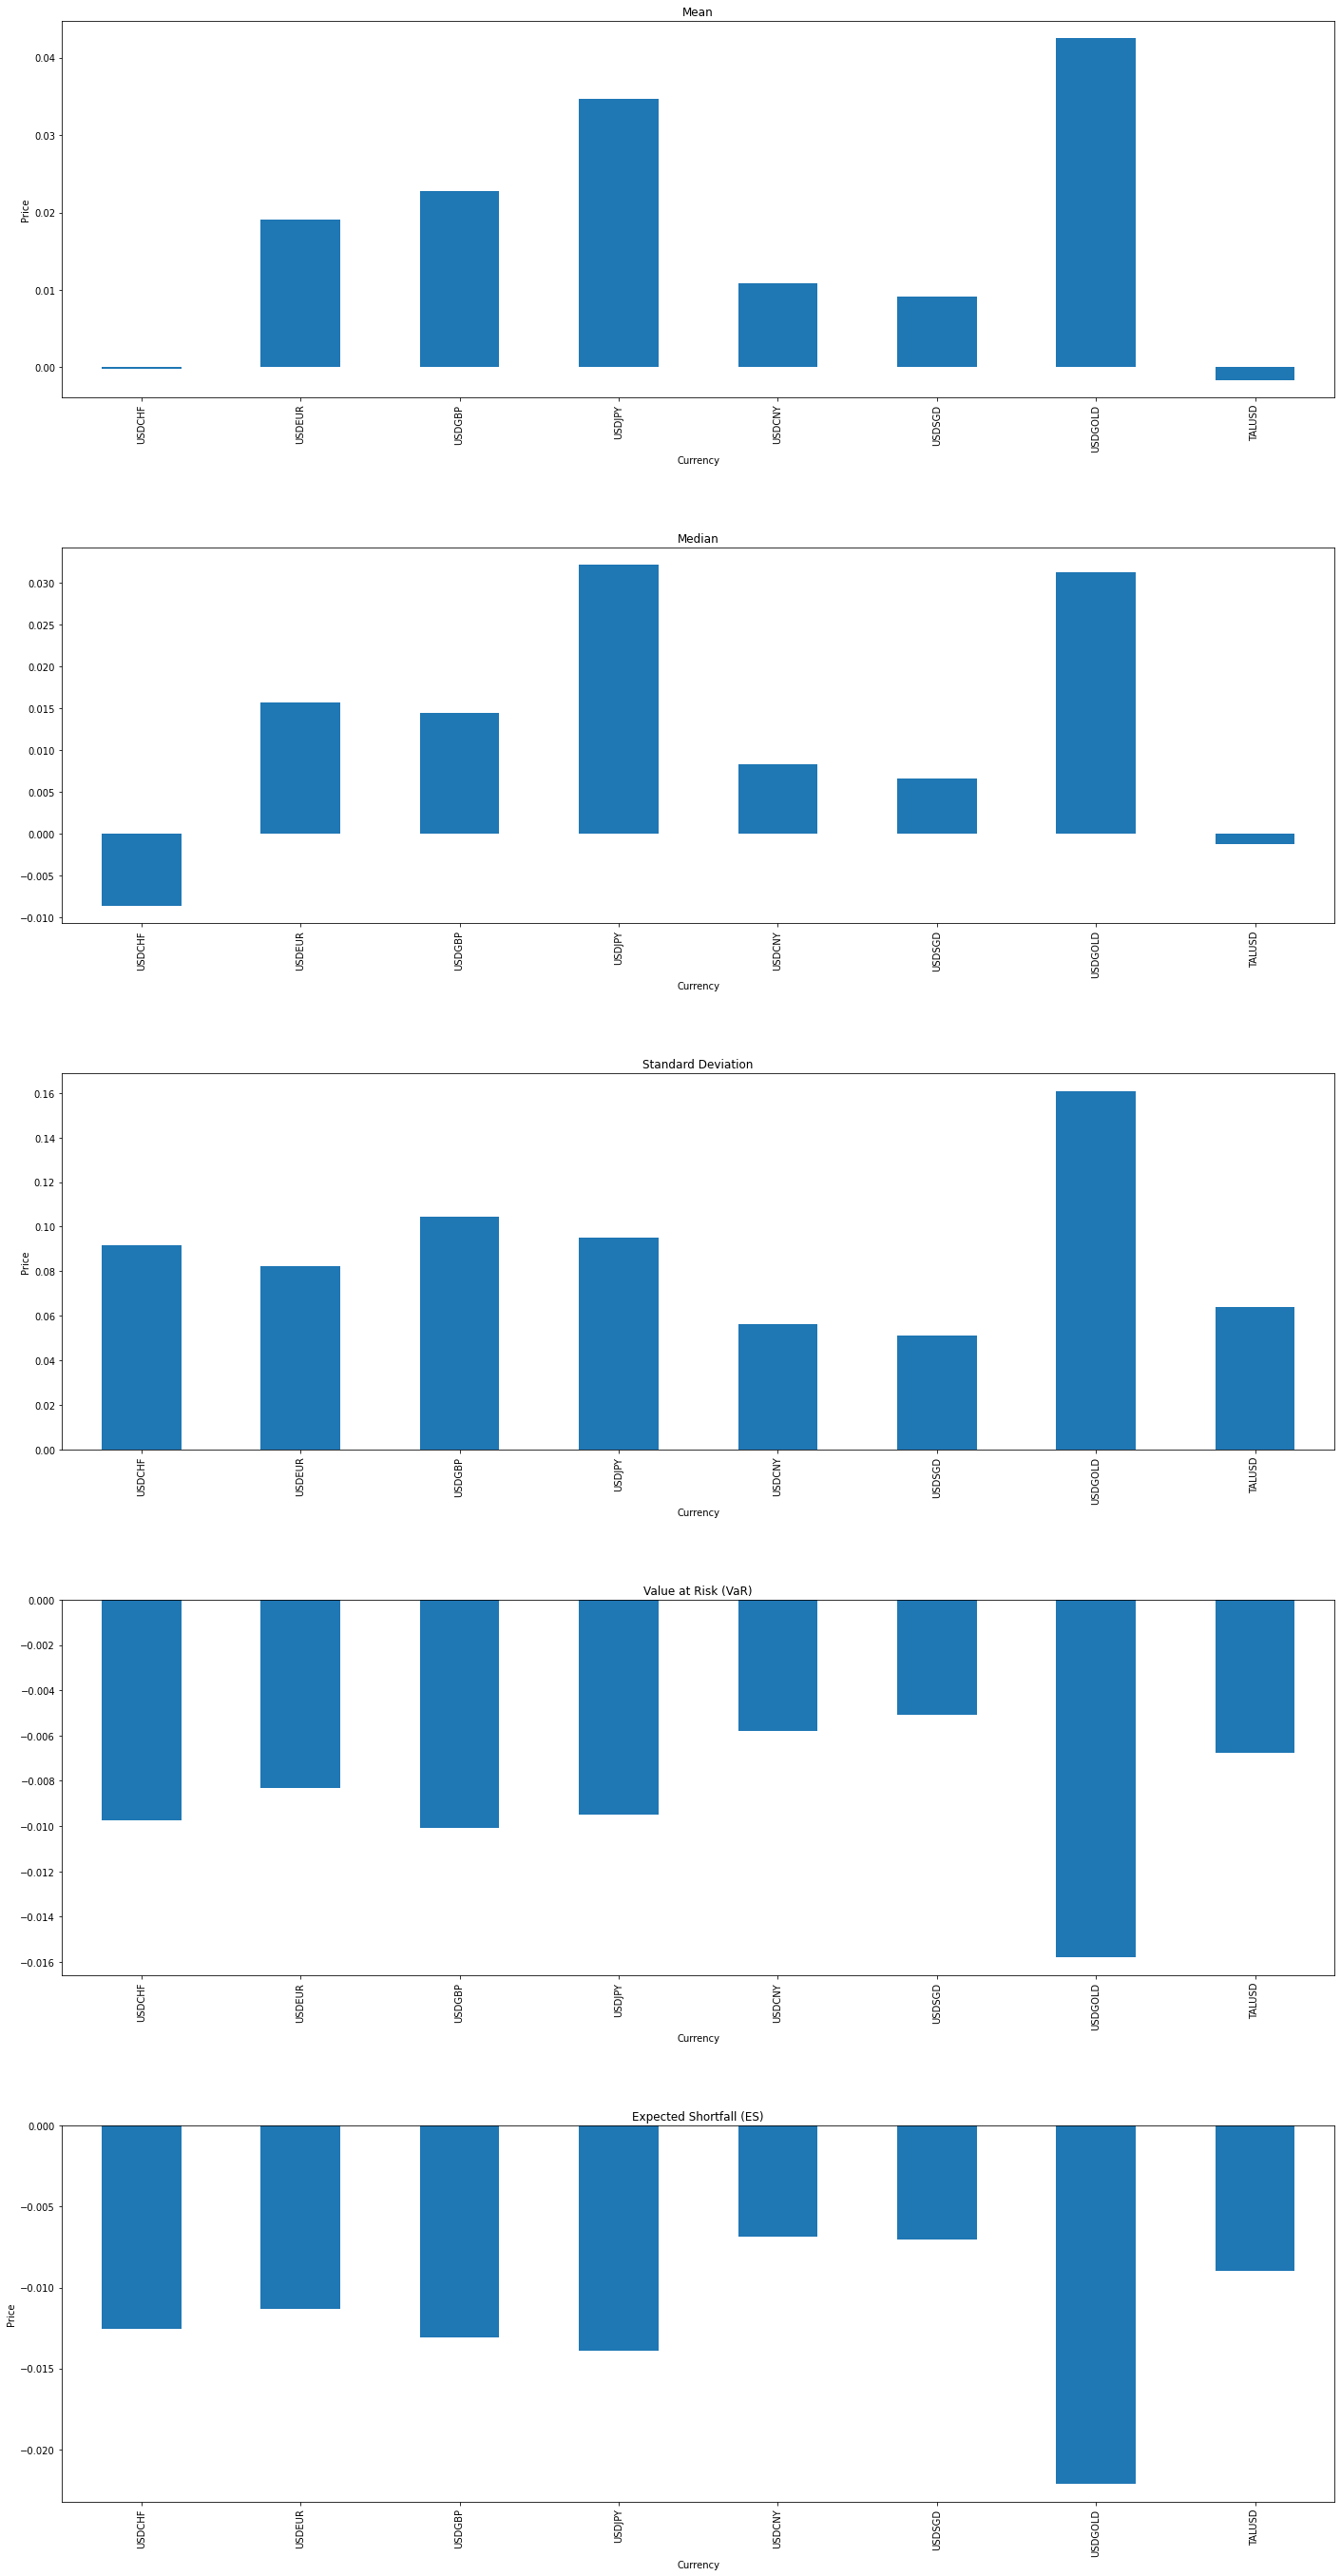

In [132]:
plot_all(stats_df)

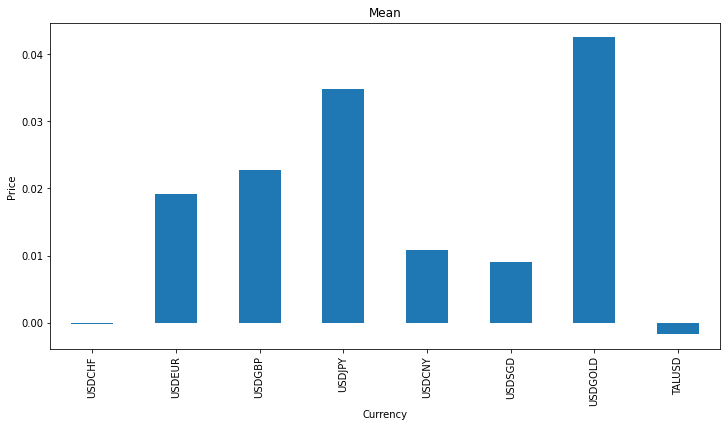

In [133]:
fig1, ax1 = plt.subplots(figsize=(12, 6))
stats_df.plot(x="Currency", y="Mean", kind="bar", ax=ax1, legend=False)
ax1.set_title("Mean")
ax1.set_ylabel("Price")
plt.show()


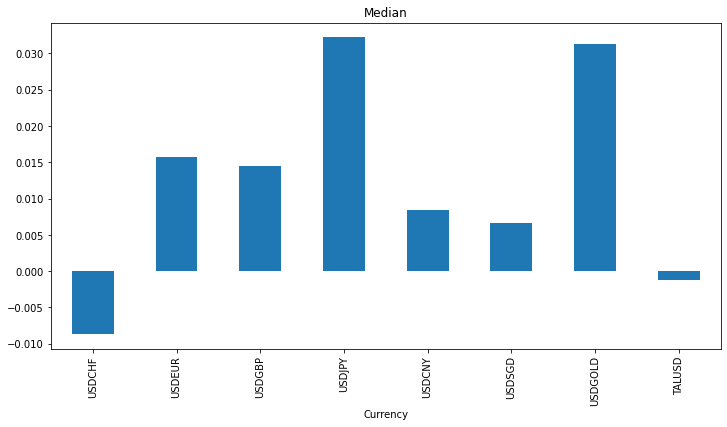

In [134]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
stats_df.plot(x="Currency", y="Median", kind="bar", ax=ax2, legend=False)
ax2.set_title("Median")
plt.show()


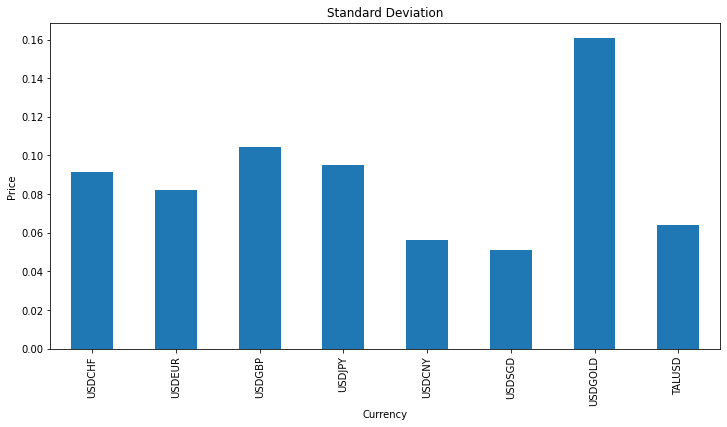

In [135]:
fig3, ax3 = plt.subplots(figsize=(12, 6))
stats_df.plot(x="Currency", y="Standard Deviation", kind="bar", ax=ax3, legend=False)
ax3.set_title("Standard Deviation")
ax3.set_ylabel("Price")
plt.show()


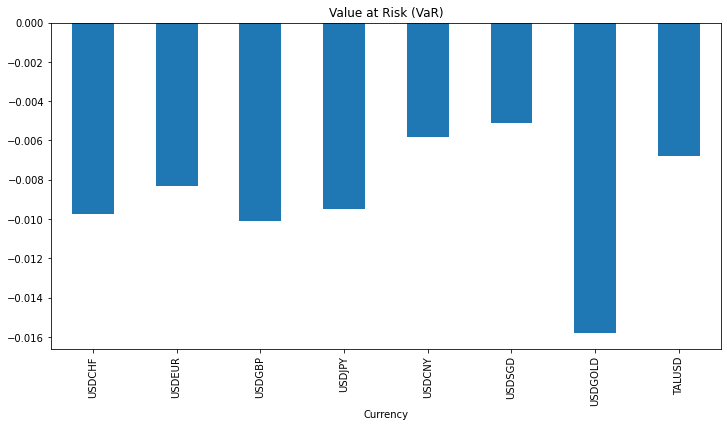

In [136]:
fig4, ax4 = plt.subplots(figsize=(12, 6))
stats_df.plot(x="Currency", y="VaR", kind="bar", ax=ax4, legend=False)
ax4.set_title("Value at Risk (VaR)")
plt.show()


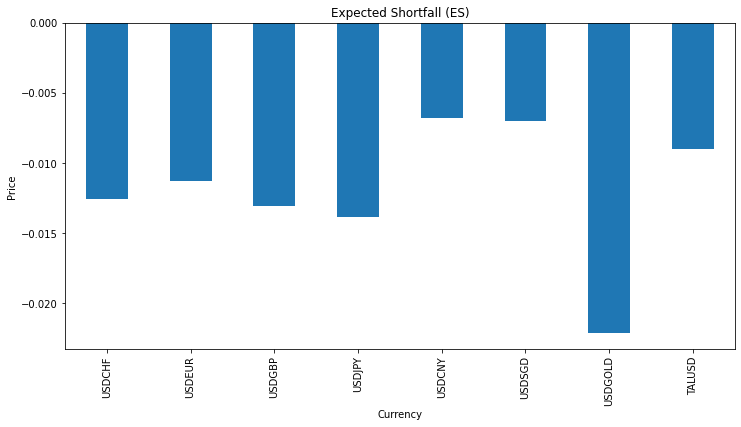

In [137]:
fig5, ax5 = plt.subplots(figsize=(12, 6))
stats_df.plot(x="Currency", y="ES", kind="bar", ax=ax5, legend=False)
ax5.set_title("Expected Shortfall (ES)")
ax5.set_ylabel("Price")
plt.show()
